# Logistic regression using PyTorch

- Dataset
- Uses torch Linear and Sigmoid
- Our own cost function

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import pprint as pp

import torch
from torch.utils.data import DataLoader

## Test data

(-3, 10)

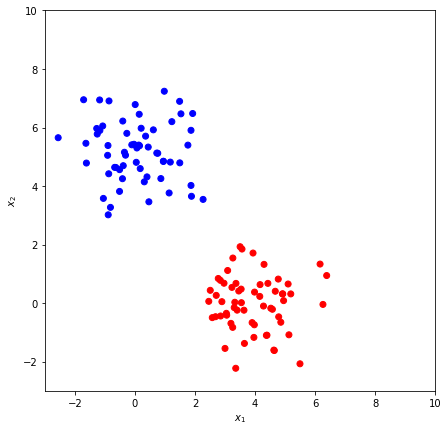

In [58]:
np.random.seed(0)

from sklearn import datasets
n_samples = 120
x, y = datasets.make_blobs(n_samples=n_samples, n_features=2, centers=[(0,5),(4,0)], random_state=0)

plt.figure(figsize=(7,7))
plt.scatter(x[:,0], x[:,1], c=y, cmap=cm.bwr)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.xlim(-3,10)
plt.ylim(-3,10)

## Torch dataset

We will create a dataset class that will be used by dataloader to present batches during training.

In [59]:
from torch.utils.data import Dataset
class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        sample = {
            'feature': torch.tensor(self.x[idx], dtype=torch.float32), 
            'label': torch.tensor(np.array([self.y[idx]]), dtype=torch.float32)}
        return sample

Testing our dataset.  

In [60]:
import pprint as pp

dataset = MyDataset(x, y)
print('length: ', len(dataset))
for i in range(5):
    pp.pprint(dataset[i])

length:  120
{'feature': tensor([-0.8955,  5.3869]), 'label': tensor([0.])}
{'feature': tensor([-0.6343,  4.6373]), 'label': tensor([0.])}
{'feature': tensor([ 5.4945, -2.0700]), 'label': tensor([1.])}
{'feature': tensor([ 4.3764, -1.0994]), 'label': tensor([1.])}
{'feature': tensor([-0.3873,  4.6977]), 'label': tensor([0.])}


Using dataloader to construct batches for training purposes

In [62]:
dataset = MyDataset(x, y)
batch_size = 4
shuffle = True
num_workers = 4
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
for i_batch, samples in enumerate(dataloader):
    print('\nbatch# = %s' % i_batch)
    print('samples: ')
    pp.pprint(samples)
    break # Otherwise it prints too much stuff


batch# = 0
samples: 
{'feature': tensor([[-0.1032,  5.4106],
        [ 0.1774,  4.5982],
        [ 0.4023,  4.3152],
        [ 0.9473,  4.8450]]),
 'label': tensor([[0.],
        [0.],
        [0.],
        [0.]])}


## Logistic regression model

In [10]:
import torch.nn as nn
class LogisticRegression(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegression, self).__init__()
        
        num_classes = 2
        self.linear = nn.Linear(input_size, num_classes-1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out = self.linear(x)
        return self.sigmoid(out)

## Loss

In [11]:
import torch.nn as nn
class MyLoss(nn.Module):
    def __init__(self):
        super(MyLoss, self).__init__()
        
    def forward(self, predictions, targets):
        n = len(predictions)
        return torch.sum((torch.abs(torch.sub(targets,predictions))))

## Accuracy

Counting how many predictions were correct.

In [37]:
def accuracy(predictions, labels):
    l = labels.type(torch.ByteTensor)
    p = (predictions > 0.5)
    s = torch.sum(p.eq(l))
    return s.item()

## Training

In [63]:
import torch.nn.functional as F

model = LogisticRegression(2)
criterion = MyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  

dataset = MyDataset(x, y)
batch_size = 16
shuffle = True
num_workers = 4
training_sample_generator = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

num_epochs = 50
for epoch in range(num_epochs):
    n = 0
    for batch_i, samples in enumerate(training_sample_generator):
        predictions = model(samples['feature'])
        error = criterion(predictions, samples['label'])
        n += accuracy(predictions, samples['label'])
        optimizer.zero_grad()
        error.backward()        
        optimizer.step()
    if epoch % 20 == 0:
        print('epoch %d:' % epoch, error.item())
    print('accuracy', n)
    if n > .99 * 120:
        break

epoch 0: 1.575107455253601
accuracy 112
accuracy 120


## Visualizing results

torch.Size([1, 2500])
torch.Size([1, 2500])
torch.Size([2500, 2])
torch.Size([2500, 1])
(50, 50)
[0 0 1 1 0 0 1 0 0 0 1 0 1 1 0 1 0 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 1 0 1 1 0
 0 0 1 0 0 1 0 0 1 0 0 0 1 0 1 0 0 1 1 0 1 0 1 0 0 0 0 1 1 0 1 0 0 1 0 0 0
 0 0 0 1 0 1 1 1 0 1 1 0 0 0 0 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 0 1 0 1 1 0 1 0 0]


Text(0.5,1,'Classification results')

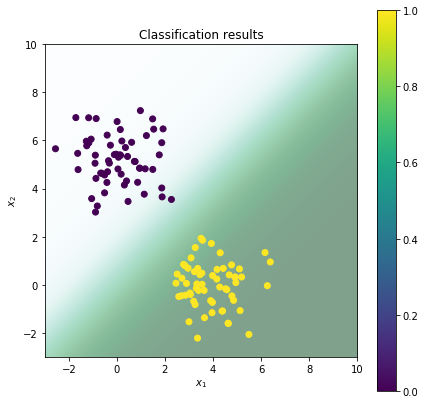

In [64]:
xcoord = np.linspace(-3, 10)
ycoord = np.linspace(-3, 10)
xx, yy = np.meshgrid(xcoord, ycoord)
xxt = torch.tensor(xx, dtype=torch.float32).view(-1).unsqueeze(0)
yyt = torch.tensor(yy, dtype=torch.float32).view(-1).unsqueeze(0)
print(xxt.shape)
print(yyt.shape)
v = torch.t(torch.cat([xxt,yyt]))
print(v.shape)
m = model(v)
print(m.shape)
mm = m.detach().numpy().reshape(50,50)
print(mm.shape)

x_try = torch.tensor(x, dtype=torch.float32)
y_try = model(x_try)
yy_try = (y_try.squeeze() > 0.5).numpy()
print(yy_try)

plt.figure(figsize=(7,7))
extent = -3, 10, -3, 10
plt.imshow(mm, cmap=cm.BuGn, interpolation='bilinear', extent=extent, alpha=.5, origin='lower')
plt.scatter(x[:,0], x[:,1], c=yy_try, cmap=cm.viridis)
plt.colorbar()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.xlim(-3,10)
plt.ylim(-3,10)
plt.title('Classification results')